# Homework #4 Part I

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [loc, scale]
>Metropolis: [df]


Sampling 4 chains for 2_000 tune and 3_000 draw iterations (8_000 + 12_000 draws total) took 6 seconds.


Effective sample size for df parameter: df    1703.94
Name: ess_bulk, dtype: float64


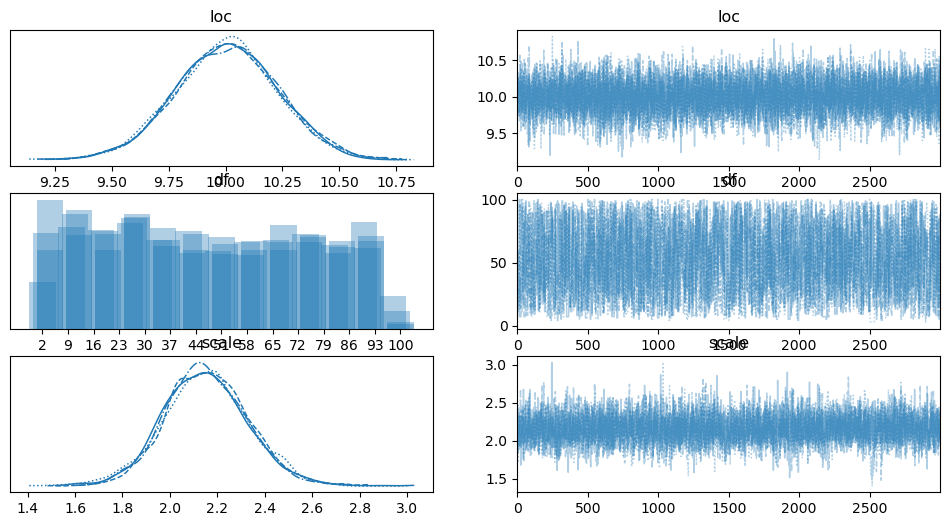

In [3]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az

mu_0, sigma_0 = 0, 10
n, loc_true, scale_true, df_true = 100, 10, 2, 15

# Generate some data
x = stats.t(df=df_true, loc=loc_true, scale=scale_true).rvs(n)

# Bayesian model specification using PyMC
with pm.Model() as model:
    # Priors for unknown model parameters
    loc = pm.Normal('loc', mu=mu_0, sigma=sigma_0)
    scale = pm.HalfNormal('scale', sigma=5)
    df = pm.DiscreteUniform('df', lower=1, upper=100)

    # Likelihood (sampling distribution) of observations
    x_obs = pm.StudentT('x_obs', mu=loc, lam=1/scale**2, nu=df, observed=x)

    # Posterior sampling using default PyMC sampler (NUTS which is an advanced form of HMC)
    trace = pm.sample(draws=3000, tune=2000, target_accept=0.95)

# Analyzing the posterior samples
az.plot_trace(trace)
az.summary(trace, round_to=2)

df_summary = az.summary(trace, var_names=['df'], round_to=2)
df_ess = df_summary['ess_bulk'] 
print(f"Effective sample size for df parameter: {df_ess}")

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [loc, scale]
>Metropolis: [df]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


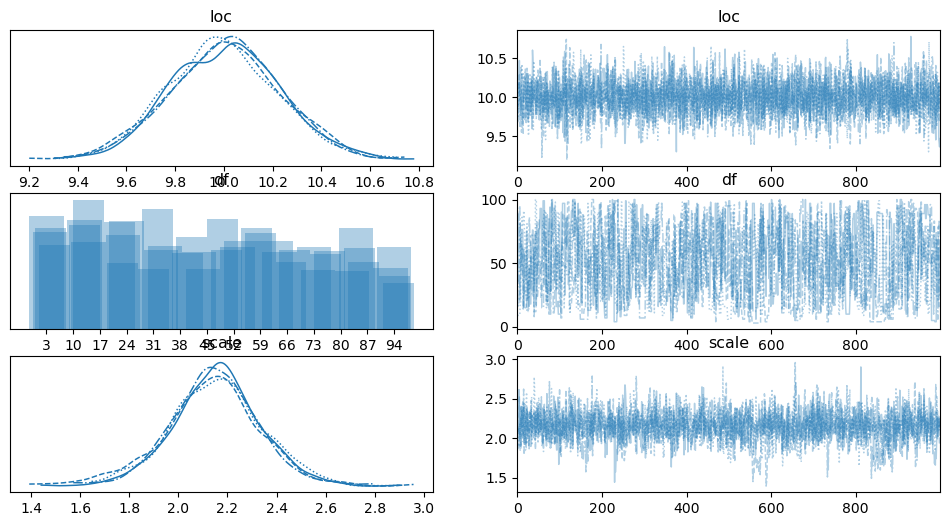

In [4]:
with pm.Model() as t_norm_half_norm_discrete:
    loc = pm.Normal("loc", mu=0, sigma=10)
    scale = pm.HalfNormal("scale", sigma=5)
    df = pm.DiscreteUniform("df", lower=1,upper=100)
    x_obs = pm.StudentT("likelihood", mu=loc, sigma=scale, nu=df, observed=x)

with t_norm_half_norm_discrete:
    idata = pm.sample()

import arviz as az; az.plot_trace(idata);

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [loc, scale]
>Metropolis: [df]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


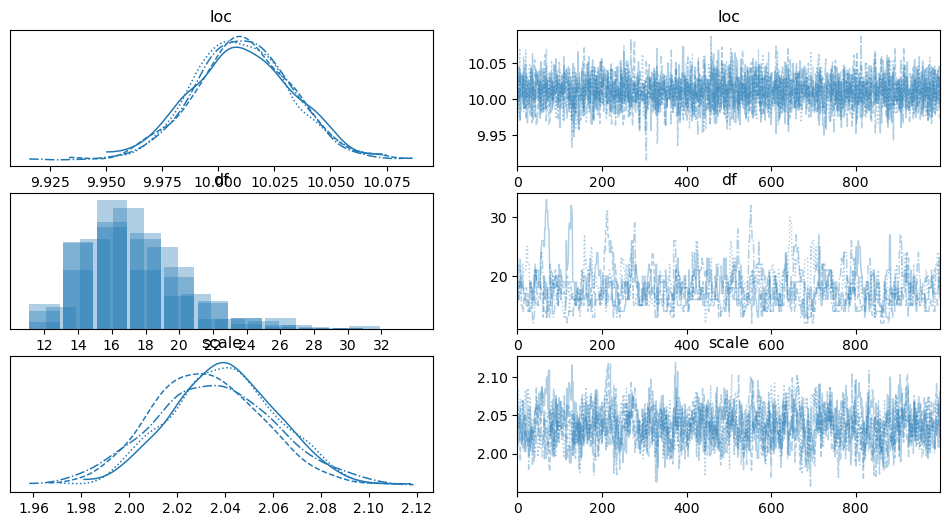

In [5]:
n,loc_true,scale_true,df_true = 10000,10,2,15 # True values data will be from... IRL, we don't know these vals.
x = stats.t(df = df_true, loc = loc_true, scale = scale_true).rvs(n) # Data from location-scale-t distn.

with pm.Model() as t_norm_half_norm_discrete:
    loc = pm.Normal("loc", mu=0, sigma=10)
    scale = pm.HalfNormal("scale", sigma=5)
    df = pm.DiscreteUniform("df", lower=1,upper=100)
    x_obs = pm.StudentT("likelihood", mu=loc, sigma=scale, nu=df, observed=x)
    idata = pm.sample()

import arviz as az; az.plot_trace(idata);

# Homework #4 Part II

In [8]:
import numpy as np
J = 8
y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])

with pm.Model() as Centered_eight:

    mu = pm.Normal("mu", mu=0, sigma=5)
    tau = pm.HalfCauchy("tau", beta=5)
    theta = pm.Normal("theta", mu=mu, sigma=tau, shape=J) # theta is length J=8
    obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=y)
    
SEED = [10082, 83457] 
with Centered_eight:
    fit_C = pm.sample(5000, chains=2, tune=1000, random_seed=SEED,
                      return_inferencedata=True, idata_kwargs={"log_likelihood": True})

with pm.Model() as NonCentered_eight:

    mu = pm.Normal("mu", mu=0, sigma=5)
    tau = pm.HalfCauchy("tau", beta=5)
    theta_tilde = pm.Normal("theta_t", mu=0, sigma=1, shape=J)

    theta = pm.Deterministic("theta", mu + tau * theta_tilde)
    obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=y)

with NonCentered_eight:
    fit_NC = pm.sample(5000, chains=2, tune=1000, random_seed=SEED,
                       return_inferencedata=True, idata_kwargs={"log_likelihood": True})


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [mu, tau, theta]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 10 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [mu, tau, theta_t]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 5 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


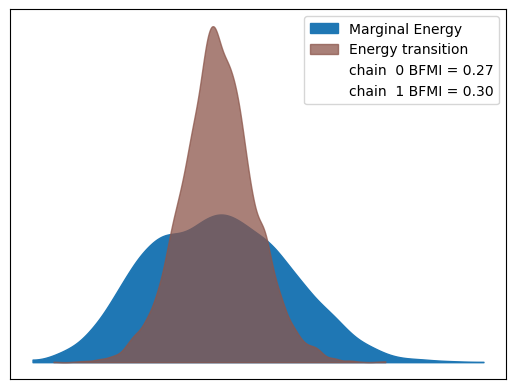

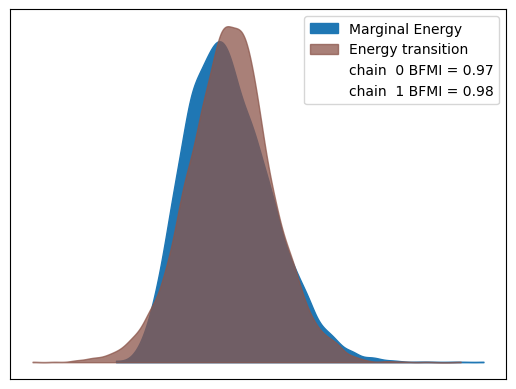

In [9]:
import arviz as az
az.plot_energy(fit_C);
az.plot_energy(fit_NC);

The Bayesian Fraction of Missing Information (BFMI) exhibits low values for both chains (0.27 and 0.30), indicating a mismatch between the energy distribution of transitions and the marginal energy distribution. This discrepancy suggests potential issues with sampling efficiency, hinting that the "centered" parameterization may impede the Hamiltonian Monte Carlo (HMC) algorithm's ability to explore the posterior distribution effectively.

Conversely, the BFMI values approach 1 (0.97 and 0.98), indicating a closer alignment between the energy transition and the marginal energy distribution. This suggests that the "uncentered" model facilitates a more efficient exploration of the posterior distribution by the HMC sampler, aligning with expectations that "uncentering" can mitigate problems related to energy function curvature.

The diagnostic findings support the idea that "uncentered" parameterizations enhance the HMC algorithm's performance by mitigating potential issues in the posterior distribution, such as high curvature, which can impede effective sampling. This is evidenced by the higher BFMI values and improved overlap between energy transition and marginal energy distributions in the "uncentered" model compared to the "centered" model.

In conclusion, the diagnostic plot indicates that the "uncentered" model offers a more favorable configuration for the HMC algorithm to produce efficient samples from the posterior distribution, reinforcing previous findings regarding the advantages of "uncentering" in enhancing HMC sampling efficiency.